In [1]:
import librosa
from librosa.feature import melspectrogram
from librosa.core import load
from librosa.display import specshow
from librosa import power_to_db

import matplotlib.pyplot as plt

# from utils.preprocessing import extract_log_mel_feats
# run git log чтобы посмотреть предыдущие версии кода, где не было исправлений

In [2]:
import os
from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np

from librosa.feature import melspectrogram
from librosa.core import load as load_wav
from librosa import power_to_db

label_to_id = {
    "airconditioner": 0, 
    "carhorn": 1, 
    "childrenplaying": 2, 
    "dogbark": 3, 
    "drilling": 4, 
    "engineidling": 5, 
    "gunshot": 6, 
    "jackhammer": 7, 
    "siren": 8, 
    "street_music": 9
}


def extract_log_mel_feats(set_type, path_to_csv, target_folders, path_to_files, out_path, sr, fft_size, hop, n_mels):
    """
    Extract features from given files and store them in binary format.

    :param set_type:
    :param path_to_csv: path to loaded csv
    :param path_to_files: path to loaded data
    :param out_path: path to store extracted features
    :param sr: input files sample rate
    :param fft_size: size of fft window
    :param hop: hop size
    :param n_mels: number of mel band

    :return:

    """
    set_type = set_type.lower()
    if set_type not in ['train', 'test']:
        raise Exception('Such set type not supported: {}'.format(set_type))

    feats = []

    if set_type == 'train':
        # meta = pd.read_csv(path_to_csv, skiprows=1, names=['fname', 'label', 'manually_verified'])
        meta = pd.read_csv(path_to_csv)
        meta_target = meta[meta.fold.isin(target_folders)]

        file_names = list(meta_target['slice_file_name'])
        folders = list(meta_target['fold'])
        n_files = len(file_names)
        label_ids = list(meta_target['classID'])

        print('Total files:', n_files)

        for i, (file_name, folder_num, label_id) in tqdm(enumerate(zip(file_names, folders, label_ids))):
            wav_data, sr = load_wav(os.path.join(os.path.join(path_to_files, f"fold{folder_num}"), file_name), sr=sr)
            mel_spec = melspectrogram(wav_data, n_fft=fft_size, hop_length=hop, n_mels=n_mels, fmax=sr // 2)
            log_mel_spec = power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
                'label_id': label_id
            })
        pickle.dump(feats, open(out_path, 'wb'))    
        return label_to_id
    else:
        meta = pd.read_csv(path_to_csv)
        meta_target = meta[meta.fold.isin(target_folders)]
        file_names = list(meta_target['slice_file_name'])
        folders = list(meta_target['fold'])
        n_files = len(file_names)

        print('Total files:', n_files)

        for i, (file_name, folder_num) in tqdm(enumerate(zip(file_names, folders))):
            wav_data, sr = load_wav(os.path.join(os.path.join(path_to_files, f"fold{folder_num}"), file_name), sr=sr)
            if len(wav_data) == 0:
                # print('Empty file:', file_name)
                wav_data = np.zeros(sr)
            mel_spec = melspectrogram(wav_data, n_fft=fft_size, n_mels=n_mels, fmax=sr // 2)
            log_mel_spec = power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
            })

    pickle.dump(feats, open(out_path, 'wb'))

In [28]:
train_folders = [f'D:/ITMO/Master/term_2/ED/UrbanSound8K/fold{i+1}/' for i in range(7)]
test_folders = [f'D:/ITMO/Master/term_2/ED/UrbanSound8K/fold{i+1}/' for i in range(7, 10)]

sample_rate = 11025
fft_size = 1024
overlap = 4
hop = fft_size // overlap
mels = 64

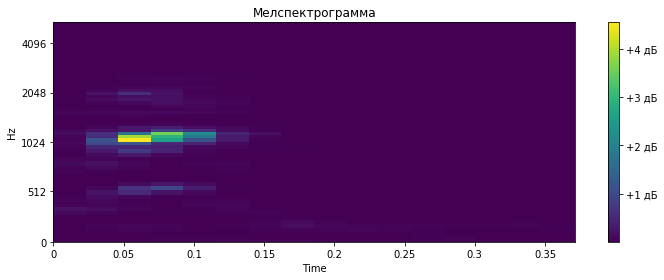

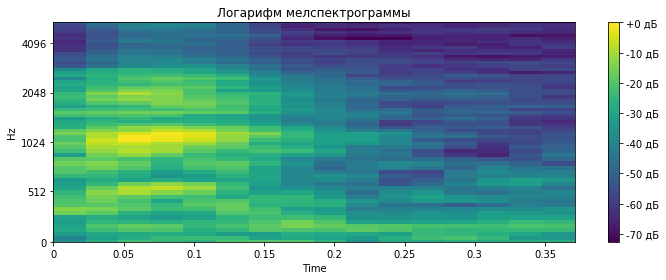

In [4]:
wav_data, sr = load(os.path.join(test_folders[0], '4918-3-0-0.wav'), sr=sample_rate)
mel_spec = melspectrogram(wav_data, n_fft=fft_size, hop_length=hop, n_mels=mels, 
                          fmax=sample_rate//2)

plt.figure(figsize=(10, 4))
colors = 'viridis'
specshow(mel_spec, y_axis='mel', fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Мелспектрограмма')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
specshow(power_to_db(mel_spec, ref=np.max), y_axis='mel',
         fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Логарифм мелспектрограммы')
plt.tight_layout()
plt.show()

In [7]:
# path_to_csv = os.path.join('./data', 'train.csv')
path_to_csv = r"D:\ITMO\Master\term_2\ED\UrbanSound8K\UrbanSound8K.csv"

pickle_train_path = os.path.join(r'D:\ITMO\Master\term_2\ED\cnn_res', 'train.pickle')
pickle_test_path = os.path.join(r'D:\ITMO\Master\term_2\ED\cnn_res', 'test.pickle')

# label_to_id = extract_log_mel_feats('train', path_to_csv, [i+1 for i in range(7)], r"D:\ITMO\Master\term_2\ED\UrbanSound8K", 
#                                     pickle_train_path, sample_rate, fft_size, hop, mels)
# id_to_label = [label for label, i in label_to_id.items()]

extract_log_mel_feats('test', path_to_csv, [i+1 for i in range(7, 10)], r"D:\ITMO\Master\term_2\ED\UrbanSound8K", pickle_test_path, sample_rate, fft_size, hop, mels)

4it [00:00, 25.49it/s]

Total files: 2459


2459it [07:00,  5.84it/s]


In [29]:
import numpy as np
import pandas as pd
import soundfile as sf
import torch.nn.functional as F
import torch.nn as nn
import torch


class DummyNetwork(nn.Module):
    def __init__(self):
        super(DummyNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, stride=(1, 1))
        
        self.mp = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
        
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.3)
        
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.bn2 = nn.BatchNorm2d(num_features=96)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        
        self.flat = nn.Flatten()
        
        # 33856 - должно соответствовать форме self.flat
        self.fc1 = nn.Linear(33856, 41)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout3(x)
        
        x = self.flat(x)
        # здесь можно еще добавить полносвязных слой или слои
        x = self.fc1(x)
        return x


In [30]:
random_input = torch.randn(1, 1, 64, 64, requires_grad=True)
network = DummyNetwork()
output = network(random_input)
print(output)

tensor([[ 0.7601, -0.5220,  0.3718,  0.6554,  1.3336,  0.7131, -0.2565, -0.5939,
          1.4848,  0.6666,  0.6183,  0.5908,  0.6771,  1.2765,  0.6204, -0.0670,
          0.4438, -1.7257, -0.0493, -0.8146, -0.2924,  0.3027,  0.1555,  0.5765,
         -0.2166,  0.6219,  0.7534,  0.3271, -0.1312,  0.8078,  0.1982, -0.8471,
         -0.5854,  0.4425,  1.2320,  0.2667, -0.9823, -0.5517,  0.4347, -0.4220,
         -0.3067]], grad_fn=<AddmmBackward>)


In [31]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(network.parameters(), lr=0.001)
optimizer.zero_grad()

random_input = torch.randn(3, 1, 64, 64, requires_grad=True)

output = network(random_input)
target = torch.empty(3, dtype=torch.long).random_(5)

loss = criterion(output, target)

print(loss.item())

loss.backward()
optimizer.step() 

3.73415207862854


In [32]:
import pickle

pickle_train_data = pickle.load(open(pickle_train_path, 'rb'))

In [33]:
def prepare_shape(feature):
    tmp = feature
    N = 64 # размер во времени (можно увеличить, должно стать лучше)
    while tmp.shape[1] < N:
        # можно попробовать сделать np.pad для коротких файлов, вместо повторения до необходимой длины
        tmp = np.hstack((tmp, tmp))
    # случайный сдвиг должен улучшить результат (для этого нужно функцию перенести в EventDetectionDataset)
    tmp = tmp[np.newaxis, :, :N]
    return tmp

In [34]:
# можно улучшить, используя сбалансированное валидационное множество
# гуглить stratified train test split sklearn
validation_set_size = 800

x_val = []
y_val = []

x_tr = []
y_tr = []

for i, row in enumerate(pickle_train_data):
    feature = prepare_shape(row['feature'])
    if i < validation_set_size:
        x_val.append(feature)
        y_val.append(row['label_id'])
    else:
        x_tr.append(feature)
        y_tr.append(row['label_id'])
x_val = np.asarray(x_val)
x_tr = np.asarray(x_tr)

y_val = np.asarray(y_val)
y_tr = np.asarray(y_tr)

In [35]:
from torch.utils.data import Dataset


class EventDetectionDataset(Dataset):
    def __init__(self, x, y=None):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # добавить сюда prepare_shape()
        if self.y is not None:
            return self.x[idx], self.y[idx]
        return self.x[idx]

In [36]:
train_dset = EventDetectionDataset(x_tr, y_tr)
val_dset = EventDetectionDataset(x_val, y_val)

2


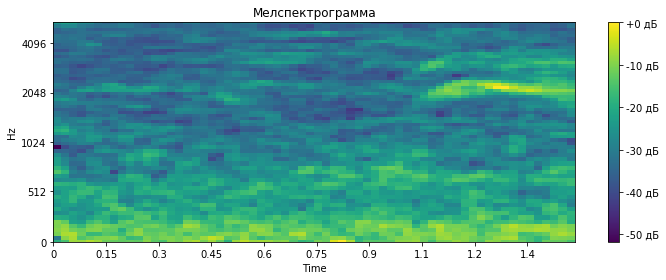

In [16]:
sample_x, sample_y = val_dset[2]
print(sample_y)
# print(id_to_label[sample_y])
plt.figure(figsize=(10, 4))
colors = 'viridis'
specshow(sample_x[0], y_axis='mel', fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Мелспектрограмма')
plt.tight_layout()
plt.show()

In [37]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dset, batch_size=41, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dset, batch_size=41, shuffle=False, num_workers=0)

In [18]:
from sklearn.metrics import accuracy_score

In [19]:
n_epoch = 50
criterion = nn.CrossEntropyLoss()
network = DummyNetwork()
# можно попробовать другой optimizer, тоже считается улучшением
optimizer = optim.SGD(network.parameters(), lr=0.001)

train_loss = []
val_loss = []

train_acc = []
val_acc = []

for e in range(n_epoch):
    print('epoch #', e)
    # train
    loss_list = []
    outputs = []
    targets = []
    for i_batch, sample_batched in enumerate(train_loader):
        x, y = sample_batched
        optimizer.zero_grad()

        output = network(x)
        outputs.append(output.detach().numpy().argmax(axis=1))
    
        target = y
        targets.append(target)
        
        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    y_true = np.hstack(targets)
    y_pred = np.hstack(outputs)
    acc = accuracy_score(y_true, y_pred)
    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    print('mean train loss:', train_loss[-1])
    print('train accuracy:', acc)
    
    
    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(val_loader):
            x, y = sample_batched
#             optimizer.zero_grad()

            output = network(x)
            outputs.append(output.detach().numpy().argmax(axis=1))

            target = y
            targets.append(target)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())
#             loss.backward()
#             optimizer.step()
            
        y_true = np.hstack(targets)
        y_pred = np.hstack(outputs)
        acc = accuracy_score(y_true, y_pred)
        val_loss.append(np.mean(loss_list))
        val_acc.append(acc)
        print('mean val loss:', val_loss[-1])
        print('val accuracy:', acc)

epoch # 0
mean train loss: 2.3626914789427573
train accuracy: 0.31664534989950666
mean val loss: 2.5643154084682465
val accuracy: 0.275
epoch # 1
mean train loss: 1.6765016121650809
train accuracy: 0.4533162799196053
mean val loss: 2.4978484988212584
val accuracy: 0.3125
epoch # 2
mean train loss: 1.4795557460678157
train accuracy: 0.5139777087520555
mean val loss: 2.3542759701609612
val accuracy: 0.30625
epoch # 3
mean train loss: 1.3461710539326739
train accuracy: 0.5439429928741093
mean val loss: 2.2083562314510345
val accuracy: 0.4
epoch # 4
mean train loss: 1.2433688142406407
train accuracy: 0.5757354284670199
mean val loss: 2.103287822008133
val accuracy: 0.46875
epoch # 5
mean train loss: 1.1980224060478495
train accuracy: 0.6049698520007308
mean val loss: 2.302848678827286
val accuracy: 0.4125
epoch # 6
mean train loss: 1.0937340455268747
train accuracy: 0.6283573908276996
mean val loss: 2.915473037958145
val accuracy: 0.33875
epoch # 7
mean train loss: 1.059906223816658
train 

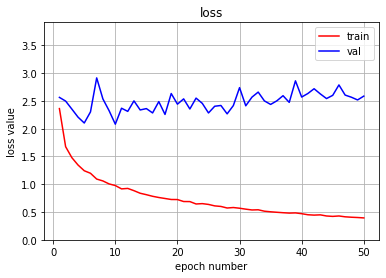

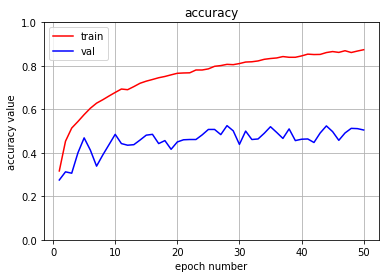

In [20]:
epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(val_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, val_loss, 'b', label='val')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, val_acc, 'b', label='val')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()

# 4. Изменить optimizer на Adam

In [38]:
n_epoch = 50
criterion = nn.CrossEntropyLoss()
network = DummyNetwork()
# можно попробовать другой optimizer, тоже считается улучшением
optimizer = optim.Adam(network.parameters(), lr=0.001) # !!! CHANGED

train_loss = []
val_loss = []

train_acc = []
val_acc = []

for e in range(n_epoch):
    print('epoch #', e)
    # train
    loss_list = []
    outputs = []
    targets = []
    for i_batch, sample_batched in enumerate(train_loader):
        x, y = sample_batched
        optimizer.zero_grad()

        output = network(x)
        outputs.append(output.detach().numpy().argmax(axis=1))
    
        target = y
        targets.append(target)
        
        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    y_true = np.hstack(targets)
    y_pred = np.hstack(outputs)
    acc = accuracy_score(y_true, y_pred)
    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    print('mean train loss:', train_loss[-1])
    print('train accuracy:', acc)
    
    
    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(val_loader):
            x, y = sample_batched
#             optimizer.zero_grad()

            output = network(x)
            outputs.append(output.detach().numpy().argmax(axis=1))

            target = y
            targets.append(target)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())
#             loss.backward()
#             optimizer.step()
            
        y_true = np.hstack(targets)
        y_pred = np.hstack(outputs)
        acc = accuracy_score(y_true, y_pred)
        val_loss.append(np.mean(loss_list))
        val_acc.append(acc)
        print('mean val loss:', val_loss[-1])
        print('val accuracy:', acc)

epoch # 0
mean train loss: 3.3580936237947263
train accuracy: 0.34734149460990316
mean val loss: 2.807303784787655
val accuracy: 0.3875
epoch # 1
mean train loss: 1.9051245192983257
train accuracy: 0.47177050977526036
mean val loss: 2.9924068093299865
val accuracy: 0.305
epoch # 2
mean train loss: 1.5092444931393239
train accuracy: 0.547049150374566
mean val loss: 2.7857666380703447
val accuracy: 0.39125
epoch # 3
mean train loss: 1.1921560595284646
train accuracy: 0.6214142152384433
mean val loss: 2.9328973799943925
val accuracy: 0.38875
epoch # 4
mean train loss: 1.029972350864268
train accuracy: 0.6733053170107802
mean val loss: 2.6272671639919283
val accuracy: 0.44375
epoch # 5
mean train loss: 0.9272570721249083
train accuracy: 0.7025397405444911
mean val loss: 2.6443576216697693
val accuracy: 0.50125
epoch # 6
mean train loss: 0.8311605122107179
train accuracy: 0.731226018636945
mean val loss: 2.706140379142016
val accuracy: 0.53125
epoch # 7
mean train loss: 0.6940350383520126
t

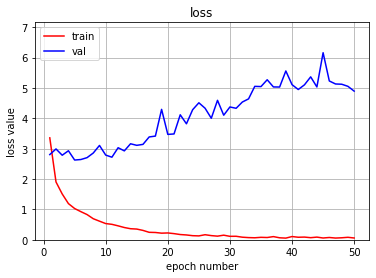

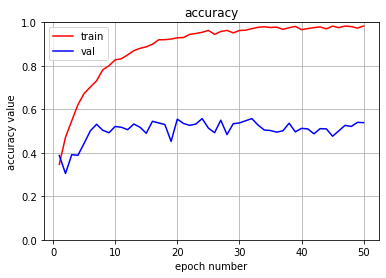

In [39]:
epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(val_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, val_loss, 'b', label='val')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, val_acc, 'b', label='val')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()

# 6. Добавить новый полносвязный и/или сверточный слой в класс модели

In [48]:
class DummyNetwork2(nn.Module):
    def __init__(self):
        super(DummyNetwork2, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, stride=(1, 1))
        
        self.mp = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
        
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.3)
        
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.bn2 = nn.BatchNorm2d(num_features=96)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        
        self.flat = nn.Flatten()
        
        # 33856 - должно соответствовать форме self.flat
        self.fc0 = nn.Linear(33856, 1000) # !!! ADDED
        self.fc1 = nn.Linear(1000, 41)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout3(x)
        
        x = self.flat(x)
        x = self.fc0(x)
        # здесь можно еще добавить полносвязных слой или слои
        x = self.fc1(x)
        return x

In [50]:
from time import time
n_epoch = 50
criterion = nn.CrossEntropyLoss()
network = DummyNetwork2()
# можно попробовать другой optimizer, тоже считается улучшением
optimizer = optim.Adam(network.parameters(), lr=0.001, weight_decay=0.0001) # !!! CHANGED

train_loss = []
val_loss = []

train_acc = []
val_acc = []

for e in range(n_epoch):
    print('epoch #', e)
    # train
    start_time = time()
    loss_list = []
    outputs = []
    targets = []
    for i_batch, sample_batched in enumerate(train_loader):
        x, y = sample_batched
        optimizer.zero_grad()

        output = network(x)
        outputs.append(output.detach().numpy().argmax(axis=1))
    
        target = y
        targets.append(target)
        
        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    y_true = np.hstack(targets)
    y_pred = np.hstack(outputs)
    acc = accuracy_score(y_true, y_pred)
    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    print('mean train loss:', train_loss[-1])
    print('train accuracy:', acc)
    
    
    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(val_loader):
            x, y = sample_batched
#             optimizer.zero_grad()

            output = network(x)
            outputs.append(output.detach().numpy().argmax(axis=1))

            target = y
            targets.append(target)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())
#             loss.backward()
#             optimizer.step()
            
        y_true = np.hstack(targets)
        y_pred = np.hstack(outputs)
        acc = accuracy_score(y_true, y_pred)
        val_loss.append(np.mean(loss_list))
        val_acc.append(acc)
        end_time = time()
        print('mean val loss:', val_loss[-1])
        print('val accuracy:', acc)
        print(f'Takes: {end_time-start_time} s')

epoch # 0
mean train loss: 19.501272610764005
train accuracy: 0.2632925269504842
mean val loss: 7.670703899860382
val accuracy: 0.26
Takes: 158.068932056427 s
epoch # 1
mean train loss: 3.655884936674317
train accuracy: 0.4047140507948109
mean val loss: 4.08190444111824
val accuracy: 0.3075
Takes: 148.62419652938843 s
epoch # 2
mean train loss: 2.004905938212551
train accuracy: 0.473780376393203
mean val loss: 2.601693719625473
val accuracy: 0.38375
Takes: 154.94038271903992 s
epoch # 3
mean train loss: 1.5899952863579365
train accuracy: 0.5225653206650831
mean val loss: 2.8663331151008604
val accuracy: 0.335
Takes: 154.37152552604675 s
epoch # 4
mean train loss: 1.4409211495919014
train accuracy: 0.5676959619952494
mean val loss: 2.7737363636493684
val accuracy: 0.4325
Takes: 149.99047088623047 s
epoch # 5
mean train loss: 1.4894940208143264
train accuracy: 0.5640416590535355
mean val loss: 2.888362763822079
val accuracy: 0.45125
Takes: 154.934907913208 s
epoch # 6
mean train loss: 1.

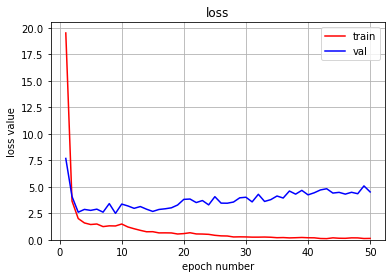

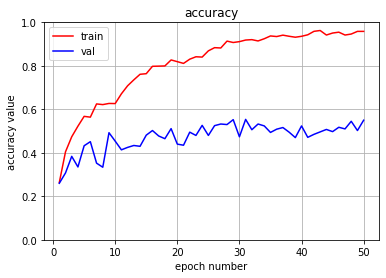

In [51]:
epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(val_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, val_loss, 'b', label='val')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, val_acc, 'b', label='val')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()